v1d: 
   * select by catalog i<24 (70 000 objects)
   * use QSO LSST catalog Mi(z=0), MBH -->  paper2 to get tau, SFinf --> generate LCs
   * use SFinf, 1.5*SFinf,  2*SFinf  to gauge how much the effect depends on the input variability 
   * test whether we get the same effect simulating 10,100,or 1000 points per light curve (it shouldn't, but who knows - computational implementation details ... ) 
   * select by HSC-epoch (t=20 yrs), r<19 , and a random sample of identical number of objects
   * plot histogram of dmag  = mag(t=20yr) - mag(t=0yrs)  ,  as well as dmag vs redshift 
    for both samples 
   * since SF controls the strenght of the effect , plot SF vs redshift , as well as histogram of SF 
   * plot the histogram of mag(t=20yr) - r_SEED (the qso catalog r-band magnitude used to initialize the simulated light curve)  
   * plot counts vs mag 


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
from astropy.table import unique
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [2]:
qso = Table.read('../catalogs/simQuasars_v1.1.dat', format='ascii',
                names=['ra', 'dec','MB','Mi','MBH','redshift',
                       'DM','alpha','u','g','r','i','z','y', 
                       'tau','SFu','SFg','SFr','SFi','SFz','SFy']
                )
# add an identifier 
qso['dbId'] = np.arange(len(qso)) 


Ok, I use the r-band relations from Paper2 : 
    with SDSS-PS1 data:
   * $\tau$ A=2.597,  B=0.17,  C = 0.035 , D = 0.141  , 
   * SF$_{\infty}$, A=-0.476, B=-0.479, C =0.118 , D = 0.118 
  
The model is 

$\log_{10}(f) = A + B \log_{10}(\lambda_{RF}/4000 A) + C (M_{i}+23)  + D \log_{10}(M_{BH} / 10^{9} M_{\circ})$

with $f = \tau, SF_{\infty}$
 
$\lambda_{RF}$ is calculated from $z$, given that $\lambda_{OBS}$ is taken as the center of each bandpass: 

for LSST ugrizy,   the bandpass centers are 

ugrizy   


so  $\lambda_{RF} = \lambda_{OBS} / (1+z)$

Since the relations were calculated for SDSS-PS1 r-band, use them for LSST r-band, centered on 615 nm .

NOTE:  in Paper2  **Mi is assumed at z=2** (as in Shen2011), whereas in this LSST mock qso catalog,  **Mi is at quasar rest-frame** ... Would need to somehow shift that to z=2 using k-correction . One way is to use Richards+2006 relationship, whereby 
Mi(z=2) = ... Mi(z) . 


In [3]:
lambdaOBSr = 6204 # angstroms 
qso['lambdaRFr'] = lambdaOBSr / (1+qso['redshift'])

log10tau = 2.597 + 0.17 * np.log10(qso['lambdaRFr'] / 4000) +\
  0.035 * (qso['Mi']+23) + 0.141*np.log10(qso['MBH'] / 1e9)
qso['tauRF_r'] = np.power(10,log10tau)

qso['tauOBS_r'] = qso['tauRF_r'] * (1+qso['redshift'])

log10sf = -0.476 -0.479 * np.log10(qso['lambdaRFr'] / 4000) + \
0.118 * (qso['Mi']+23) + 0.118*np.log10(qso['MBH'] / 1e9)
qso['sf_r'] = np.power(10,log10sf)

These are rest-frame values.  Convert to observed frame: amplitude unchanged, but $\tau_{RF} = \tau_{OBS} / (1+z)$  , so $\tau_{OBS} = \tau_{RF}  *(1+z)$ - since we want to make light curves in the OBSERVED frame ! 

## Pre-selection : cut the catalog at i<24,  make LCs for all objects 

In [4]:
# pre-selection
mag_cut = 24
m = qso['i'] < mag_cut
print('There are %d quasars brighter than %f'%(np.sum(m), mag_cut))
qso_sample = qso[m]

There are 69152 quasars brighter than 24.000000


### Make light curves  for all : 

In [9]:
import modules as mod 
import celerite

Sampling : enough to span the duration from SDSS (1998-2004) to HSC  (2015-2018). 

In [44]:
# Use mag-dependent LSST model  for photometric uncertainty ... 
#LSST error model 
def calc_lsst_error(m):
    # Calculate LSST error based on the magnitude of the observed light curve ...
    # we use magnitude-dependent single-visit 
    # formula for r-band from 
    # https://www.lsst.org/sites/default/files/docs/sciencebook/SB_3.pdf
    # https://www.lsst.org/scientists/scibook
    # https://arxiv.org/abs/0912.0201
    # See Chap.3, Sec. 3.5, Eq. 3.1, Table. 3.2
     # mag 
    sigma_sys = 0.005
    gamma = 0.039 
    m5 = 24.7
    x = np.power(10,0.4 * (m-m5))
    sigma_rand = np.sqrt(  (0.04-gamma) * x + gamma * x*x ) 
    sigma = np.sqrt(sigma_sys**2.0 + sigma_rand**2.0)
    return sigma



Simulate 65k light curves (still tau, SF taken from the paper2 relationship, using the LSST QSO catalog Mi(z=0), MBH) 

Also, simulate the same using the catalog SF, tau ... 

In [ ]:
# a 20-year light curve, such as 
# between 1998 and 2018, i.e. SDSS to HSC, 
# with Npts epochs 
Npts = 1000
t = np.linspace(0, 20*365, Npts) 


# used SFr, tau
f = '1.0'
name = str(Npts)+'pts_'+f+'SFr'
outDir = '../data_products/qso_'+name+'/' # : 
if not os.path.exists(outDir):
    os.mkdir(outDir)
# used  3*sf_r, tauOBS_r

sample  = qso_sample
sample['dmag'] = 0.0 
sample['rmag0yr'] = 0.0 
sample['rmag20yr'] = 0.0 
for i in range(len(sample)):
    # sf_r, tauOBS_r  are derived values 
    SF_inf = float(f)*sample['sf_r'][i]  
    tau_in = sample['tauOBS_r'][i] 
    mean_mag = sample['r'][i]

    lcname = str(sample['dbId'][i])
    # simulate ideal light curve
    y_true = mod.sim_DRW_lightcurve(t, SF_inf, tau_in , mean_mag)

    # add noise corresponding to mag-dependent error model...
    y_err = calc_lsst_error(y_true)

    # simulate the observed light curve 
    y_obs = y_true + y_err * np.random.normal(loc=0,scale=1,size=len(y_true))

    # store the r-band observed light curve ... (time, mag, mag_err )
    lc_obs = Table([t, y_true, y_obs, y_err], 
                  names=['t','magtrue', 'magobs', 'magerr'])
    lc_obs.write(outDir+lcname+'.txt', format='ascii', overwrite=True)

    # store the dmag 
    delta_mag = lc_obs['magobs'][-1] - lc_obs['magobs'][0]
    sample['dmag'][i] = delta_mag
    sample['rmag0yr'][i] = lc_obs['magobs'][0]    # SDSS epoch : 1998
    sample['rmag20yr'][i] = lc_obs['magobs'][-1]  # HSC epoch  : 2018 
    
# store the catalog ... 
sample.write('../catalogs/qso_lsst_catalog_i_lt_24_'+name+'.txt', format='ascii')



### Plot diagnostic diagrams 

There are  3517 objects brigher  at last epoch than   20
median($\mathrm{r}_{\mathrm{OBS,20yr}}<20$)= 
-0.028877
median(random)= 
-0.014356


/epyc/opt/anaconda/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/epyc/opt/anaconda/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/epyc/opt/anaconda/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wi

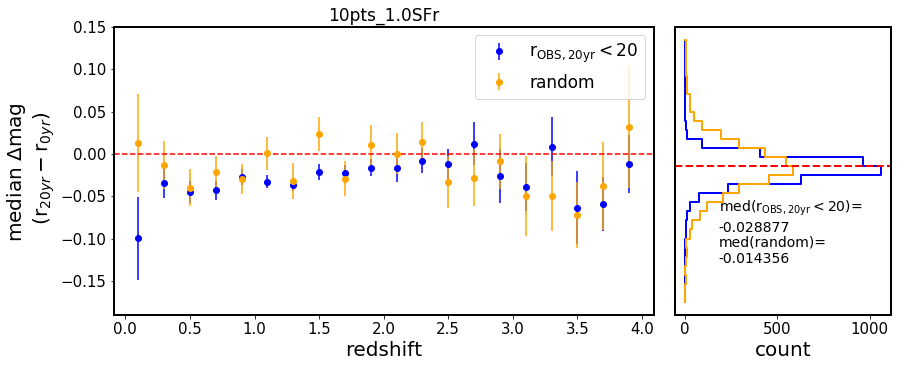

In [48]:
%matplotlib inline

from scipy.stats import binned_statistic as bs 
sigmaG = lambda x : 0.7413*(np.percentile(x,75) - np.percentile(x,25))
#from astroML import stats

#Npts = 500

fig = plt.figure(figsize=(10, 4))
left,bottom,width,height = 0., 0., 0.75, 1
ax = fig.add_axes([left,bottom,width,height], )#xticks=[], yticks=[])
left,bottom,width,height = 0.78, 0., 0.3, 1
ax1 = fig.add_axes([left,bottom,width,height], yticks=[], )


for f in ['1.0']:#,'1.5','2.0']:
    name = str(Npts)+'pts_'+f+'SFr'
    s = Table.read('../catalog/qso_lsst_catalog_i_lt_24_'+name+'.txt', format='ascii')
    #fig,ax = plt.subplots(1,1,figsize=(8,4))

    # plot dmag (between SDSS and HSC epochs) for simulated LCs 
    # (with variability and LSST photometric uncertainty added )

    z_bins = np.arange(0,4.2, 0.2)

    # sample 1 : select by HSC epochs r<20  (since simulated is r-band !! )
    magCut = 20
    m1  = s['rmag20yr'] < magCut
    N = np.sum(m1)
    print('There are ', N , 'objects brigher  at last epoch than  ', magCut)

    # sample 2 : select at random similar number of objects without such steep cut 
    indices =np.arange(len(s))
    m2 = np.random.choice(indices, size=N, replace=False)


      
    font = 14
    y0 = 0.3
    x0 = 0.2
    dy = 0.12
    i = 0 
    
    for m,c,l in zip([m1,m2], ['blue','orange'],
                    [r'$\mathrm{r}_{\mathrm{OBS,20yr}}<20$', 'random']):
        
        ###
        # left axis 
        # first, plot the redshift dependence 
        ### 
        
        x = s['redshift'][m]
        y = s['dmag'][m]
        stats_med = bs(x,y, statistic='median',bins=z_bins)
        bin_centers = (stats_med.bin_edges[1:] + stats_med.bin_edges[:-1])/2.
        
        # get the count per bin 
        stats_count = bs(x,x,statistic='count', bins=z_bins)
        N = stats_count.statistic

        # get the scatter per bin, estimated from sigmaG 
        stats_rms = bs(x,y,statistic=sigmaG, bins=z_bins)
        sigma_median = 1.25 *  stats_rms.statistic / np.sqrt(N)
        
        # fmt='o', mec = 'black', mfc='white', ecolor = 'black', capthick=2,
        #    markersize=10, )

        #ax.scatter(bin_centers, stats_med.statistic, c=c, label=l)
        ax.errorbar(bin_centers,stats_med.statistic,sigma_median,
                   fmt='o', c=c, label=l)
        
        
        ######
        # right axis 
        # second: plot marignalized histogram 
        ###### 
    
        #stats = bs(s['redshift'][m],s['dmag'][m], statistic='median',bins=z_bins)
        #bin_centers = (stats.bin_edges[1:] + stats.bin_edges[:-1])/2.
        
        hist_dmag, bins_dmag = np.histogram(y, bins=30, density=False,range=(-1.75,1.75),)
        ax1.plot(hist_dmag, 0.5 * (bins_dmag[1:] + bins_dmag[:-1]
                            - bins_dmag[1] + bins_dmag[0]),lw=2,color=c, drawstyle='steps',
                label=l)
        
    
        print('median(%s)= \n%f'%(l,np.median(s['dmag'][m])))
        ax1.text(x0,y0-i * dy, 'med(%s)=\n%f'%(l,np.median(s['dmag'][m])),
                transform=ax1.transAxes, fontsize=font)
        i += 1 

        
    # setup for the right axis 
    ax1.axhline(0,ls='--', lw=2,c='red')
    ax1.set_xlabel('count')

    
    
        
    # setup for the left axis 
    ax.set_ylim(-.19,.15)
    ax.axhline(0,ls='--',c='r')
    ax.set_ylabel('median '+r'$\Delta$'+'mag \n '+r'$(\mathrm{r}_{20yr}-\mathrm{r}_{0yr})$')
    ax.set_xlabel('redshift')
    ax.legend(fontsize=17)
    ax.set_title(name, fontsize=17)
    
    
   
  

    plt.savefig('qso_lsst_cat_dmag_'+name+'.png', bbox_inches='tight',
               dpi=100)
    
    
    
    
    
    plt.savefig('qso_lsst_cat_dmag_redshift_'+name+'.png', bbox_inches='tight',
               dpi=100)


Also, plot SF as a function of redshift :  

In [30]:
s[:4]

ra,dec,MB,Mi,MBH,redshift,DM,alpha,u,g,r,i,z,y,tau,SFu,SFg,SFr,SFi,SFz,SFy,dbId,lambdaRFr,tauRF_r,tauOBS_r,sf_r,dmag,rmag0yr,rmag20yr
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
9.107491,2.592981,-15.001,-15.711,548200.0,0.11769,38.671,0.2,23.651,23.576,23.316,22.837,22.793,22.575,30.24,0.854,0.756,0.67,0.609,0.569,0.533,0,5550.734103373923,260.9124344003554,291.6192188049332,0.853374553265956,-1.2853163320481436,23.434815960131683,22.14949962808354
8.30645,4.459707,-15.006,-15.716,869900.0,0.09593,38.195,-0.39,23.192,23.087,22.842,22.355,22.305,22.083,48.63,0.89,0.787,0.698,0.634,0.592,0.555,1,5660.945498343872,279.28403002069115,306.07574702057605,0.8915019521483317,-0.43385693256310986,22.812591519252734,22.378734586689625
7.223705,4.276085,-15.004,-15.714,1297000.0,0.09925,38.274,0.12,23.27,23.169,22.922,22.437,22.387,22.166,70.25,0.931,0.824,0.731,0.664,0.62,0.581,2,5643.84807823516,295.36031439339394,324.6748255969383,0.9363906686714518,0.3370501312106988,22.825918058636,23.162968189846698
8.683838,4.808032,-15.004,-15.714,1991000.0,0.10597,38.426,0.3,23.415,23.322,23.073,22.59,22.54,22.321,38.58,0.979,0.866,0.768,0.698,0.652,0.611,3,5609.555412895468,313.4344180387278,346.6490633182918,0.987844123339023,0.27343462867330715,23.062336688424082,23.33577131709739


There are  3517 objects brigher  at last epoch than   20


/epyc/opt/anaconda/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/epyc/opt/anaconda/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/epyc/opt/anaconda/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wi

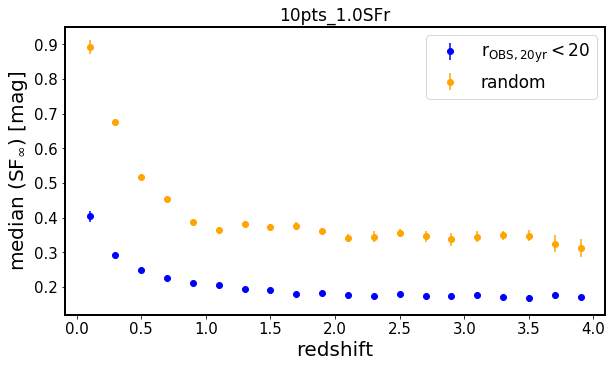

In [47]:
%matplotlib inline

from scipy.stats import binned_statistic as bs 
sigmaG = lambda x : 0.7413*(np.percentile(x,75) - np.percentile(x,25))
#from astroML import stats

#Npts = 500

fig = plt.figure(figsize=(10, 4))
left,bottom,width,height = 0., 0., 0.75, 1
ax = fig.add_axes([left,bottom,width,height], )#xticks=[], yticks=[])


for f in ['1.0']:#,'1.5','2.0']:
    name = str(Npts)+'pts_'+f+'SFr'
    s = Table.read('../catalogs/qso_lsst_catalog_i_lt_24_'+name+'.txt', format='ascii')
    #fig,ax = plt.subplots(1,1,figsize=(8,4))

    # plot dmag (between SDSS and HSC epochs) for simulated LCs 
    # (with variability and LSST photometric uncertainty added )

    z_bins = np.arange(0,4.2, 0.2)

    # sample 1 : select by HSC epochs r<20  (since simulated is r-band !! )
    magCut = 20
    m1  = s['rmag20yr'] < magCut
    N = np.sum(m1)
    print('There are ', N , 'objects brigher  at last epoch than  ', magCut)

    # sample 2 : select at random similar number of objects without such steep cut 
    indices =np.arange(len(s))
    m2 = np.random.choice(indices, size=N, replace=False)

    # starting points for plotting text on the right axis ... 
    font = 14
    y0 = 0.3
    x0 = 0.2
    dy = 0.12
    i = 0 
    
    for m,c,l in zip([m1,m2], ['blue','orange'],
                    [r'$\mathrm{r}_{\mathrm{OBS,20yr}}<20$', 'random']):
        
        ###
        # left axis 
        # first, plot the redshift dependence 
        ### 
        x = s['redshift'][m]
        y = float(f) * s['sf_r'][m] # the used SF was catalog sf_r times the multiplicative factor ... 
        
        stats_med = bs(x,y, statistic='median',bins=z_bins)
        bin_centers = (stats_med.bin_edges[1:] + stats_med.bin_edges[:-1])/2.
        
        # get the count per bin 
        stats_count = bs(x,x,statistic='count', bins=z_bins)
        N = stats_count.statistic

        # get the scatter per bin, estimated from sigmaG 
        stats_rms = bs(x,y,statistic=sigmaG, bins=z_bins)
        sigma_median = 1.25 *  stats_rms.statistic / np.sqrt(N)
        
        # fmt='o', mec = 'black', mfc='white', ecolor = 'black', capthick=2,
        #    markersize=10, )

        #ax.scatter(bin_centers, stats_med.statistic, c=c, label=l)
        ax.errorbar(bin_centers,stats_med.statistic,sigma_median,
                   fmt='o', c=c, label=l)
        
        
       

    # setup for the left axis 
    #ax.set_ylim(-.19,.15)
    
    ax.set_ylabel('median '+r'(SF$_{\infty}$) [mag]')
    ax.set_xlabel('redshift')
    ax.legend(fontsize=17)
    ax.set_title(name, fontsize=17)

    
     
    plt.savefig('qso_lsst_cat_sfr_redshift_'+name+'.png', bbox_inches='tight',
               dpi=100)


median(rOBS<20)= 
-0.028877
median(random)= 
-0.005125


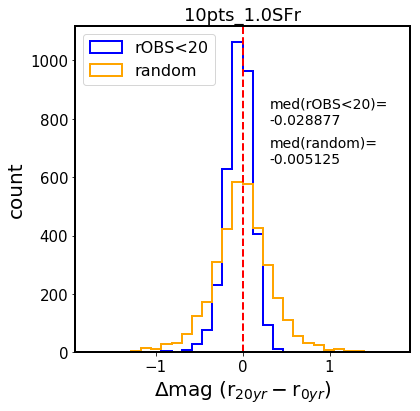

In [46]:

for f in ['1.0']:#1.5','2.0']:
    name = str(Npts)+'pts_'+f+'SFr'
    s = Table.read('../catalogs/qso_lsst_catalog_i_lt_24_'+name+'.txt', format='ascii')
    
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    f = 14
    y0 = 0.7
    x0 = 0.58
    dy = 0.12
    i = 0 
    for m,c,l in zip([m1,m2], ['blue','orange'], ['rOBS<20', 'random']):
        #stats = bs(s['redshift'][m],s['dmag'][m], statistic='median',bins=z_bins)
        #bin_centers = (stats.bin_edges[1:] + stats.bin_edges[:-1])/2.
        ax.hist(s['dmag'][m], histtype='step', lw=2, color=c, bins=30,range=(-1.75,1.75),
               label = l)

        print('median(%s)= \n%f'%(l,np.median(s['dmag'][m])))
        ax.text(x0,y0-i * dy, 'med(%s)=\n%f'%(l,np.median(s['dmag'][m])),
                transform=ax.transAxes, fontsize=f)
        i += 1 

    ax.axvline(0,ls='--', lw=2,c='red')
    ax.legend(loc='upper left', fontsize=16)
    ax.set_xlabel(r'$\Delta$'+'mag '+r'$(\mathrm{r}_{20yr}-\mathrm{r}_{0yr})$')
    ax.set_ylabel('count')
    ax.set_title(name)

    plt.savefig('qso_lsst_cat_dmag_'+name+'.png', bbox_inches='tight',
               dpi=100)

Npts

In [45]:
Npts

10

Plot an example light curve ... 

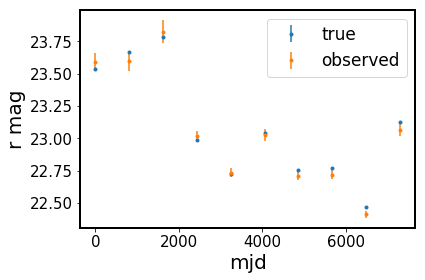

In [41]:
i = 5133
lcname = str(s['dbId'][i])
lc = Table.read(outDir+lcname+'.txt', format='ascii')
t,y_sim,y_obs,y_err = lc['t'], lc['magtrue'], lc['magobs'], lc['magerr']
plt.errorbar(t,y_sim,0, fmt=".",label='true')
plt.errorbar(t,y_obs, y_err,fmt=".", label='observed')
plt.xlabel('mjd')
plt.ylabel('r mag')
plt.legend(fontsize=17)

Plot the summary histograms 

"histogram of the magnitude difference between r (time = 20 yr), which presumably
includes both the light curve scatter and photometric error scatter, used for sample
selection, and the true apparent magnitude (the magnitude level given to the DRW
light curve generator). We want to know the mean, median, std. dev and sigma_G
for this histogram. ""

3517


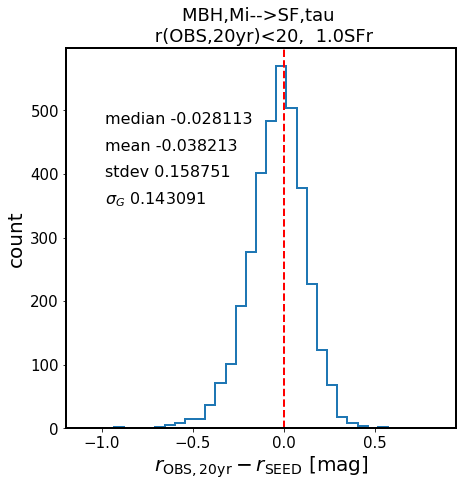

In [43]:
#from astroML import stats

for f in ['1.0']:#,'1.5','2.0']:
    name = str(Npts)+'pts_'+f+'SFr'
    s = Table.read('../catalogs/qso_lsst_catalog_i_lt_24_'+name+'.txt', format='ascii')
    
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    m = s['rmag20yr'] < 20
    print(np.sum(m))
    x = s['rmag20yr'][m]  - s['r'][m]
    ax.hist(x, histtype='step', lw=2,
           bins=35, range=(-1.1,.85))
    ax.axvline(0,ls='--',lw=2,c='r')
    ax.set_xlabel(r'$r_{\mathrm{OBS,20yr}} - r_{\mathrm{SEED}}$ [mag]')
    ax.set_ylabel('count')

    f = 16
    y0 = 0.8
    x0 = 0.1
    dy = 0.07
    ax.text(x0,y0, 'median %f'%np.median(x),transform=ax.transAxes,
           fontsize=f)
    ax.text(x0,y0-dy, 'mean %f'%np.mean(x),transform=ax.transAxes,
           fontsize=f)
    ax.text(x0,y0-2*dy, 'stdev %f'%np.std(x),transform=ax.transAxes,
           fontsize=f)
    ax.text(x0,y0-3*dy, r'$\sigma_{G} \,\, %f$ '%sigmaG(x),transform=ax.transAxes,
           fontsize=f)
    ax.set_title('MBH,Mi-->SF,tau \n r(OBS,20yr)<20,  '+name[6:])
    #ax.set_title('Using QSO catalog SFr, tau ')
    plt.savefig('qso_lsst_catalog_i_lt_20_histogram'+name+'.png', 
                bbox_inches='tight', dpi=100)